# Car Racing DQN agent 
Training a DQN agent for the OpenAI gym Car-Racing-v0 environment.


### Notes
- The first 50 frames afer resetting the environment are of the camera zooming into the track, and look very different from "normal" gameplay.
    - I exclude these frames from the training of each episode.
- Preprocessing
    - I have applied similar preprocessing steps as used in the DeepMind paper.
    - Images are converted to grayscale and cropped to $56 x 56$ to reduce dimensionality and speed up training.
    - Consecutive frames are then stacked to form a $56 x 56 x 3$ image, where the channels represent the game screen at different points in time instead of RGB channels.
- How often the target network weights are updated seems to make a BIG difference on training performance. Less seems to be more.

### To do
- Research literature.
- Increase replay buffer size.
- Trial simplified CNN architectures.
- Add more frames to the frame stack.
- Adjust max consecutive negative rewards threholds.
- Trial different epsilon decay schedules.

### Environment setup

        conda create -c conda-forge -n gymenv swig pip  
        conda activate gymenv  
        pip install gym==0.17.3
        pip install Box2D gym
        pip install gym[all]

        pip install tensorflow
        pip install matplotlib

        pip install gym pyvirtualdisplay   
        sudo apt-get install -y xvfb python-opengl ffmpeg  

        # The following steps are so that I can access the new env in Azure ML notebooks
        conda install ipykernel
        python -m ipykernel install --user --name gymenv --display-name "Python (gymenv)"




### Useful links

#### Papers
https://arxiv.org/pdf/1312.5602.pdf 

#### Environment setup  
https://stackoverflow.com/questions/60268769/gyms-box-2d-openai-doesnt-install-successfully-pip-error  
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-access-terminal#add-new-kernels  

#### Code adapted from:   
https://keras.io/examples/rl/deep_q_network_breakout/  
https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c  
https://pythonprogramming.net/training-deep-q-learning-dqn-reinforcement-learning-python-tutorial/?completed=/deep-q-learning-dqn-reinforcement-learning-python-tutorial/   
https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN  
https://github.com/pekaalto/DQN 

#### Import libraries

In [1]:
import gym
import numpy as np
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from collections import deque
import time
import random
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, \
                        GlobalMaxPool2D, BatchNormalization, Dropout, Activation
from keras.backend import clear_session

display = Display(visible=0, size=(1400, 900))
display.start()

from dqn_agent import *
from dqn_agent_trainer import *

## Train the DQN agent

In [2]:
# actions = np.array([[0.0, 1.0, 0.0],  
#                     [1.0, 0.0, 0.0],
#                     [-1.0, 0.0, 0.0],
#                     [0.0, 0.0, 0.8],
#                     [0.0, 0.0, 0.0]]   
#                 )
# action_probs = np.array([0.5] + [(1 - 0.5)/4.0] * 4)

actions = np.array([[0.0, 1.0, 0.0],  
                    [0.0, 0.5, 0.0],  
                    [1.0, 0.0, 0.0],
                    [-1.0, 0.0, 0.0],
                    [0.0, 0.0, 1.0],
                    [0.0, 0.0, 0.5],   
                    [0.0, 0.0, 0.0]]   
                   )

action_probs = [0.35, 0.15] + [(1 - 0.5)/5.0] * 5


dqn_agent = DQNAgent(actions,
                    action_probs,
                    lr=0.00025, 
                    batch_size=32, 
                    gamma=0.95)

agent_trainer = DQNAgentTrainer(img_len=56, 
                                frame_stack_num=4, 
                                number_of_episodes=800, 
                                epsilon=1.0, 
                                epsilon_min=0.05, 
                                epsilon_step_episodes=100.0,
                                final_epsilon_episode=600,
                                max_replay_memory_size=100000, 
                                min_replay_memory_size=1000, 
                                random_action_frames=2000,
                                max_consecutive_negative_rewards=50, 
                                update_target_model_frames=5000, 
                                max_frames_per_episode=10000,
                                skip_frames=4, 
                                save_training_frequency=10000, 
                                save_models=False, 
                                save_run_results=True,
                                verbose_cnn=50, 
                                verbose=True)

env = gym.make("CarRacing-v0")
agent_trainer.train_agent(env, dqn_agent)


/anaconda/envs/gymenv/lib/python3.10/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2022-04-09 21:17:46.367873: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-09 21:17:46.367945: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x-wing): /proc/driver/nvidia/version does not exist
2022-04-09 21:17:46.368607: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Episode: 0
Track generation: 1069..1340 -> 271-tiles track
Ending episode: done False, consecutive negative rewards 51
Total frames in episode: 63
Replay buffer size: 63
Total frame count: 63
Epsilon: 1.0
Total reward for episode: 15.54074074074041
Running average rewards: 15.54074074074041 

Episode: 1
Track generation: 1003..1258 -> 255-tiles track


KeyboardInterrupt: 

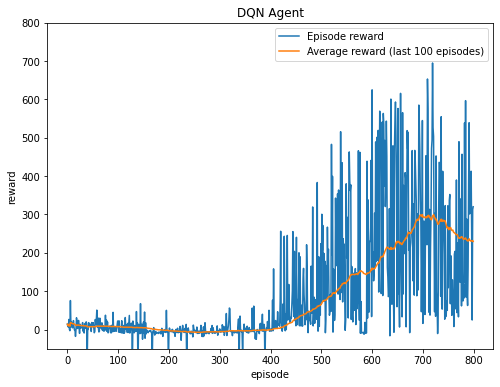

In [6]:
# Plot the rewards
episode_rewards = agent_trainer.episode_rewards

plt.figure(figsize=(8, 6))
plt.title('DQN Agent')
plt.plot(episode_rewards, label='Episode reward')
plt.plot([np.mean(episode_rewards[::-1][i:i+100]) for i in range(len(episode_rewards))][::-1], label='Average reward (last 100 episodes)')
plt.ylim((-50, 800))
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend()
plt.show()

In [2]:
with open("./runs/dqn_results_20220409-160900.pickle", 'rb') as fp:
    results = pickle.load(fp)

model = results['model']


2022-04-09 21:09:02.756199: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-09 21:09:02.756266: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x-wing): /proc/driver/nvidia/version does not exist
2022-04-09 21:09:02.757036: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [50]:
env.close()

In [2]:
def create_q_model():
    """Returns a CNN model - same architecture as in the DeepMind paper."""

    model = Sequential()
    model.add(Conv2D(32, 8, activation='relu', strides=4,
            input_shape=(56, 56, 4,)))
    model.add(Conv2D(64, 4, activation='relu', strides=2))
    model.add(Conv2D(64, 3, activation='relu', strides=1))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_actions, activation="linear"))

    return model


def image_processing(s):
    """Crop image, convert to grayscale and reshape."""

    s = s[20:76, 20:76, :]
    s = np.dot(s[...,:3], [0.2989, 0.5870, 0.1140]).astype(np.int16)
    s = np.reshape(s, (1, 56, 56))

    return s


def experience_replay(d, model, target_model, verbose=False):
    """Experience replay step."""

    # Create random batch from replay buffer
    batch = random.sample(d, BATCH_SIZE)

    # Get states
    s_0 = np.array([np.reshape(x[0], (56, 56, 4)) for x in batch])
    s_1 = np.array([np.reshape(x[3], (56, 56, 4)) for x in batch])

    # Get q values from models
    q_0 = model.predict(s_0)
    q_1 = target_model.predict(s_1)

    # Loop through batch and update q-values
    for i, (_, a, r, _, done) in enumerate(batch):
        if done:
            q_new = r
        else: 
            q_new = r + GAMMA * max(q_1[i])

        # Update the q-value
        q_0[i][a] = q_new 

    # Fit model
    model.fit(s_0, q_0, epochs=1, batch_size=BATCH_SIZE, verbose=verbose)


def get_stacked_state(grayscale_state_buffer):
    """Returns a stacked image from the grayscale buffer."""

    # Create image from grayscale buffer
    img = np.zeros((56, 56, 4))
    img[:, :, 0] = grayscale_state_buffer[0]
    img[:, :, 1] = grayscale_state_buffer[1]
    img[:, :, 2] = grayscale_state_buffer[2]
    img[:, :, 3] = grayscale_state_buffer[3]
    img = np.reshape(img, (1, 56, 56, 4))

    # Remove first image from buffer
    grayscale_state_buffer.popleft()
    return img


def generate_episode(s_0, env, d, actions, epsilon, frame_count):
    """Generate an episode of learning."""
    
    episode_reward = 0
    episode_frame_count = 0
    consecutive_negative_rewards = 0

    # Get stacked state representation
    s_0 = image_processing(s_0)
    grayscale_state_buffer = deque([s_0]*4)
    s_0_stacked = get_stacked_state(grayscale_state_buffer)

    while True:

        # Increment counters
        episode_frame_count += 1
        frame_count += 1

        # Select action
        if frame_count < RANDOM_ACTION_FRAMES or np.random.rand() < epsilon:
            a_0 = np.random.choice(np.arange(num_actions), p=PROBS)
            #a_0 = random.choice(np.arange(num_actions))
        else:
            a_0 = np.argmax(model.predict(s_0_stacked))

        # Action reward aggregates rewards over the skip frame loop
        action_reward = 0
        for _ in range(SKIP_FRAMES):
            # Take action and reshape new state
            s_1, reward, done, _ = env.step(actions[a_0])
            
            action_reward += reward
            episode_reward += reward
            if done:
                break

        # Increment consecutive negative reward counter
        if action_reward < 0:
            consecutive_negative_rewards += 1 
        else: 
            consecutive_negative_rewards = 0

        # Append latest state and get new stacked representation
        s_1 = image_processing(s_1)
        grayscale_state_buffer.append(s_1)
        s_1_stacked = get_stacked_state(grayscale_state_buffer)

        # Append (s, a, r, s') to d
        d.append((s_0_stacked, a_0, action_reward, s_1_stacked, done))

        # Start experience replay
        if len(d) >= MIN_REPLAY_MEMORY_SIZE:
            verbose = True if frame_count % VERBOSE_N == 0 else False
            experience_replay(d, model, target_model, verbose)

        # Drop the oldest experience if the length of d exceeeds MAX_REPLAY_MEMORY_SIZE
        if len(d) > MAX_REPLAY_MEMORY_SIZE:
            d.popleft()

        # Set target weights to model weights
        if frame_count % UPDATE_TARGET_MODEL_FRAMES == 0:
            target_model.set_weights(model.get_weights())

        # Save model
        if frame_count % SAVE_TRAINING_FREQUENCY == 0 and SAVE_MODELS is True:
            model.save(f'./saved_models/dqn_trial_{frame_count}.h5')

        # End the episode if following conditions are met
        if done or (episode_frame_count > MAX_FRAMES_PER_EPISODE) or (consecutive_negative_rewards > MAX_CONSECUTIVE_NEGATIVE_REWARDS):
            print(f"Ending episode: done {done}, consecutive negative rewards {consecutive_negative_rewards}")
            print(f"Total frames in episode: {episode_frame_count}")
            break

        # Current state ← new state
        s_0_stacked = s_1_stacked.copy()

    print(f'Replay buffer size: {len(d)}')
    return d, episode_reward, epsilon, frame_count


def dqn_agent(s, actions, model):
    """Returns the best action as learnt by the DQN agent."""
    s = np.reshape(s, (1, 96, 96, 3))
    action_index = np.argmax(model.predict(s))
    return actions[action_index]


In [3]:
# Discretize actions
actions = np.array([[0.0, 1.0, 0.0],  # Full throttle
                    [1.0, 1.0, 0.0],
                    [-1.0, 1.0, 0.0],
                    [-1.0, 0.8, 0.0],  # Full left, half throttle
                    [1.0, 0.8, 0.0],   # Full right, half throttle
                    [-1.0, 0.0, 0.2], # Full left, quarter brake
                    [1.0, 0.0, 0.2],  # Full right, quarter brake
                    [0.0, 0.0, 0.2],  # Quarter brake
                    [0.0, 0.0, 0.0]]   # No action
                   )

actions = np.array([[0.0, 1.0, 0.0],  
                    [0.0, 0.5, 0.0],  
                    [1.0, 0.0, 0.0],
                    [-1.0, 0.0, 0.0],
                    [0.0, 0.0, 1.0],
                    [0.0, 0.0, 0.5],   
                    [0.0, 0.0, 0.0]]   
                   )

num_actions = actions.shape[0]

# When selecting random actions, put more weight on actions that move forward.
# This seem to speed up training considerably.
# PROBS = [0.3, 0.15, 0.15] + [(1 - 0.6)/6.0] * 6
# sum(PROBS)


PROBS = [0.35, 0.15] + [(1 - 0.5)/5.0] * 5
PROBS


[0.35, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1]

In [4]:
# Init constants
NUMBER_OF_EPISODES = 1000
GAMMA = 0.95
EPSILON_MIN = 0.05
EPSILON_STEP_EPISODES = 100.0
EPSILON_STEP = (1.0 - EPSILON_MIN)/EPSILON_STEP_EPISODES
MAX_REPLAY_MEMORY_SIZE = 100000
MIN_REPLAY_MEMORY_SIZE = 1000
RANDOM_ACTION_FRAMES = 2000
MAX_CONSECUTIVE_NEGATIVE_REWARDS = 50
BATCH_SIZE = 32
UPDATE_TARGET_MODEL_FRAMES = 5000
MAX_FRAMES_PER_EPISODE = 10000
SKIP_FRAMES = 4
SAVE_TRAINING_FREQUENCY = 10000
SAVE_MODELS = False
VERBOSE_N = 50

# Create models
clear_session()
target_model = create_q_model()
model = create_q_model()
loss_function = keras.losses.Huber()
opt = Adam(learning_rate=0.00025, epsilon=1e-7, clipnorm=1.0)
model.compile(loss=loss_function, optimizer=opt, metrics=['mean_squared_error'])
target_model.compile(loss=loss_function, optimizer=opt, metrics=['mean_squared_error'])

# Init variables
epsilon = 1.0
d = deque()
episode_rewards =[]
average_rewards = []
frame_count = 0
env = gym.make("CarRacing-v0")

# Train the agent!
for i in range(NUMBER_OF_EPISODES):
    print(f'Episode: {i}')
    # Reset the environment
    _ = env.reset()

    # First 50 frames are zooming into track so ignore for training!
    for _ in range(50):
        s_0, _, _, _ = env.step([0.0, 1.0, 0.0])

    # Generate episode
    d, episode_reward, epsilon, frame_count = generate_episode(s_0, env, d, actions, epsilon, frame_count)
    episode_rewards.append(episode_reward)

    print(f'Total frame count: {frame_count}')
    print(f'Epsilon: {epsilon}')
    print(f'Total reward for episode: {episode_reward}')
    print(f'Running average rewards: {np.mean(episode_rewards[-100:])} \n')

    # Start decaying epsilon when policy is used to select actions
    if frame_count > RANDOM_ACTION_FRAMES and frame_count > MIN_REPLAY_MEMORY_SIZE:
        epsilon =  max(EPSILON_MIN, epsilon - EPSILON_STEP)

# Save model
if SAVE_MODELS is True:
    model.save(f'./saved_models/dqn_final.h5')

env.close()

2022-04-08 19:09:17.388344: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-08 19:09:17.388418: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x-wing): /proc/driver/nvidia/version does not exist
2022-04-08 19:09:17.389948: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Bad pipe message: %s [b'-\nR(\xc7/\xc2U$d\xb4\x9fC>\xe6\xce\xc1j \xd2\xe6\x0f\xc4\xdc\xdf\xbd\xdc|\n\xf3T\xc3C\t\x90\xf0\xf9\xe4G0\xcf\xd5\x89_-L\xd9\xd8l\x00\xad\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x

Episode: 0
Track generation: 1200..1504 -> 304-tiles track
Ending episode: done False, consecutive negative rewards 51
Total frames in episode: 57
Replay buffer size: 57
Total frame count: 57
Epsilon: 1.0
Total reward for episode: -2.998019801980533
Running average rewards: -2.998019801980533 

Episode: 1
Track generation: 954..1199 -> 245-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1208..1514 -> 306-tiles track
Ending episode: done False, consecutive negative rewards 51
Total frames in episode: 60
Replay buffer size: 117
Total frame count: 117
Epsilon: 1.0
Total reward for episode: 8.786885245901317
Running average rewards: 2.894432721960392 

Episode: 2
Track generation: 1010..1272 -> 262-tiles track
Ending episode: done False, consecutive negative rewards 51
Total frames in episode: 112
Replay buffer size: 229
Total frame count: 229
Epsilon: 1.0
Total reward for episode: 27.996934865901018
Running average rewards: 11.

In [8]:
env.close()

## Analysis

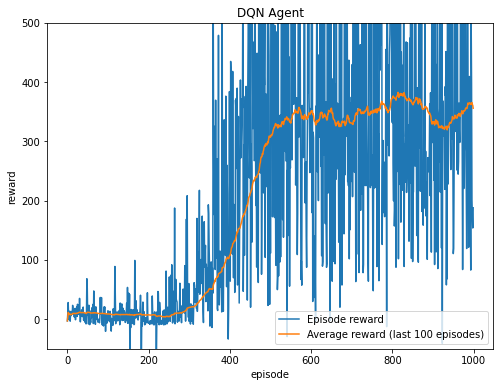

In [6]:
# Plot the rewards
plt.figure(figsize=(8, 6))
plt.title('DQN Agent')
plt.plot(episode_rewards, label='Episode reward')
plt.plot([np.mean(episode_rewards[::-1][i:i+100]) for i in range(len(episode_rewards))][::-1], label='Average reward (last 100 episodes)')
plt.ylim((-50, 500))
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend()
plt.show()

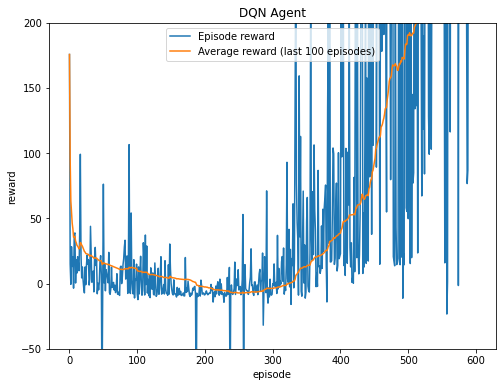

In [15]:
# Plot the rewards
plt.figure(figsize=(8, 6))
plt.title('DQN Agent')
plt.plot(episode_rewards, label='Episode reward')
plt.plot([np.mean(episode_rewards[::-1][i:i+100]) for i in range(len(episode_rewards))][::-1], label='Average reward (last 100 episodes)')
plt.ylim((-50, 200))
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend()
plt.show()

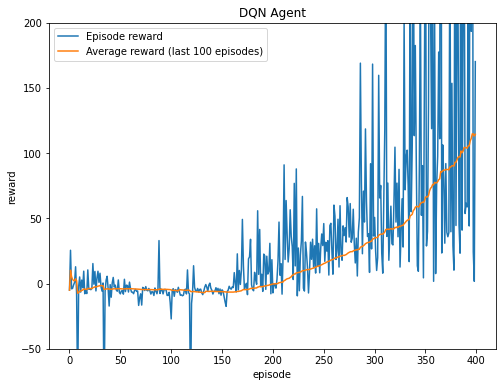

In [5]:
# Plot the rewards
plt.figure(figsize=(8, 6))
plt.title('DQN Agent')
plt.plot(episode_rewards, label='Episode reward')
plt.plot([np.mean(episode_rewards[::-1][i:i+100]) for i in range(len(episode_rewards))][::-1], label='Average reward (last 100 episodes)')
plt.ylim((-50, 200))
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend()
plt.show()

Action: [0. 1. 0.], reward: -0.4000000000000057


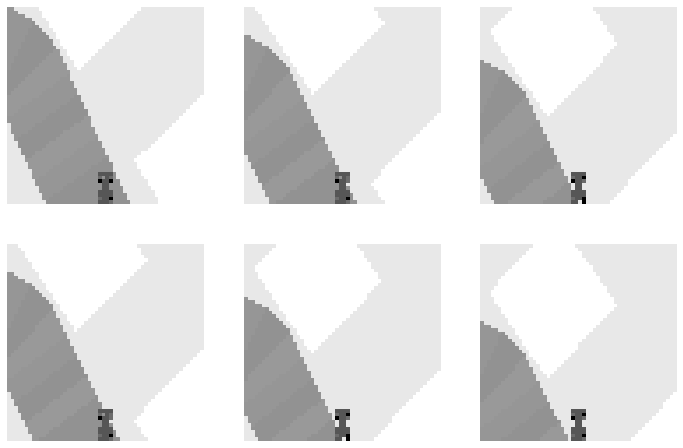

In [37]:
idx = 1015

s_0_img = d[idx][0].reshape(56, 56, 3)
s_1_img = d[idx][3].reshape(56, 56, 3)
action = actions[d[idx][1]]

print(f'Action: {action}, reward: {d[idx][2]}')
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
ax[0, 0].imshow(np.round(s_0_img[:, :, 0]), cmap='gray')
ax[0, 1].imshow(np.round(s_0_img[:, :, 1]), cmap='gray')
ax[0, 2].imshow(np.round(s_0_img[:, :, 2]), cmap='gray')

ax[1, 0].imshow(np.round(s_1_img[:, :, 0]), cmap='gray')
ax[1, 1].imshow(np.round(s_1_img[:, :, 1]), cmap='gray')
ax[1, 2].imshow(np.round(s_1_img[:, :, 2]), cmap='gray')

ax[0, 0].axis('off')
ax[0, 1].axis('off')
ax[0, 2].axis('off')
ax[1, 0].axis('off')
ax[1, 1].axis('off')
ax[1, 2].axis('off')
plt.show()

### Render the DQN agent

In [16]:
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [3]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [4]:
def get_stacked_state_live(gs_buffer):
    """Returns a stacked image from the grayscale buffer."""

    # Create image from grayscale buffer
    img = np.zeros((56, 56, 4))
    img[:, :, 0] = gs_buffer[0]
    img[:, :, 1] = gs_buffer[4]
    img[:, :, 2] = gs_buffer[8]
    img[:, :, 3] = gs_buffer[12]
    img = np.reshape(img, (1, 56, 56, 4))

    # Remove first image from buffer
    gs_buffer.popleft()
    return img

In [9]:
results['actions']

array([[ 0. ,  1. ,  0. ],
       [ 0. ,  0.5,  0. ],
       [ 1. ,  0. ,  0. ],
       [-1. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ],
       [ 0. ,  0. ,  0.5],
       [ 0. ,  0. ,  0. ]])

In [12]:
actions = results['actions']
model = results['model']

render = True

episode_rewards = 0

env = wrap_env(gym.make("CarRacing-v0"))
s_0 = env.reset()
s_0 = image_processing(s_0, 56)
grayscale_state_buffer = deque([s_0]*13)
s_0_stacked = get_stacked_state_live(grayscale_state_buffer)

i = 0
while True:
    if render:
        env.render()
    if i < 5:
        a_0 = 0
    else:
        a_0 = np.argmax(model.predict(s_0_stacked))
    s_1, reward, done, _ = env.step(actions[a_0])
    episode_rewards += reward

    if done:
        break

    # Append latest state and get new stacked representation
    s_1 = image_processing(s_1, 56)
    grayscale_state_buffer.append(s_1)
    s_0_stacked = get_stacked_state_live(grayscale_state_buffer)

    i += 1

env.close()
if render:
    show_video()

print(episode_rewards)


In [14]:
env.close()

In [ ]:
def create_q_model():
    """Returns a CNN model."""

    model = Sequential()
    model.add(Conv2D(32, 8, activation='relu', strides=4,
            input_shape=(56, 56, 3,)))
    model.add(Conv2D(64, 4, activation='relu', strides=2))
    model.add(Conv2D(64, 3, activation='relu', strides=1))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_actions, activation="linear"))

    return model

def create_q_model_2():
    """Returns a CNN model."""

    model = Sequential()
    model.add(Conv2D(16, 12, activation='relu', strides=4,
            input_shape=(96, 96, 3,)))
    model.add(Conv2D(32, 8, activation='relu', strides=2))
    model.add(Conv2D(64, 4, activation='relu', strides=2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_actions, activation="linear"))

    return model

def cnn_model():
    """Returns a CNN model."""

    model = Sequential()
    model.add(Conv2D(32, (4, 4), activation='relu', strides=1,
            input_shape=(96, 96, 3,)))
    model.add(Conv2D(64, (4, 4), activation='relu', strides=2))
    model.add(Conv2D(128, (4, 4), activation='relu', strides=2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_actions, activation="linear"))

    return model

def build_model():
    """ Neural Net for Deep-Q learning Model"""

    model = Sequential()
    model.add(Conv2D(filters=6, kernel_size=(7, 7), strides=3, activation='relu', input_shape=(56, 56, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=12, kernel_size=(4, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(216, activation='relu'))
    model.add(Dense(num_actions, activation=None))

    return model


In [ ]:
def rgb2gray(rgb):
    """Converts RGB image to grayscale.
        https://stackoverflow.com/questions/63900600/turn-a-image-to-grayscale-in-python
    """

    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]).astype(np.int16)

In [ ]:
action = [0.0, 1.0, 0.0]
gs_buffer = deque()

frame_count = 0

env = gym.make("CarRacing-v0")
s_prev = env.reset()
for i in range(50):

    action_reward = 0

    for _ in range(2):
        s_1, reward, done, info = env.step(action)
        s_1 = s_1[20:76, 20:76, :]
        s_1_gs = rgb2gray(s_1)
        frame_count+=1
        action_reward += reward

    gs_buffer.append((s_1_gs, frame_count, round(action_reward, 2)))

    if i%3==0 and i>0:
        img = np.zeros((56, 56, 3))
        img[:, :, 0] = gs_buffer[0][0]
        img[:, :, 1] = gs_buffer[1][0]
        img[:, :, 2] = gs_buffer[2][0]

        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 8))
        ax[0].imshow(img[:, :, 0], cmap='gray')
        ax[1].imshow(img[:, :, 1], cmap='gray')
        ax[2].imshow(img[:, :, 2], cmap='gray')

        ax[0].set_title(f'frame: {gs_buffer[0][1]}, reward: {gs_buffer[0][2]}')
        ax[1].set_title(f'frame: {gs_buffer[1][1]}, reward: {gs_buffer[1][2]}')
        ax[2].set_title(f'frame: {gs_buffer[2][1]}, reward: {gs_buffer[1][2]}')

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')
        plt.show()

        # Remove first image from buffer
        gs_buffer.popleft()

    s_prev = s_1.copy()

env.close()